## LSTM_tensorflow_tutorial [link](https://www.tensorflow.org/tutorials/structured_data/time_series)

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [ ]:
df = pd.read_csv('data/guadalupe_validation.csv')

In [ ]:
df.head()

In [ ]:
#### The data has already been cleaned, wind transformed to vector and added perodicity
### Check for NAN values and delete before running models

In [ ]:
### Subsample to get data for every hour (starting from index 0, get 12 steps)
df = df[0::12]

In [ ]:
df.head()

In [ ]:
date_time = pd.to_datetime(df.pop('Date_Time'), format='%Y-%m-%d %H:%M:%S')

In [ ]:
plot_cols = ['ATAvg', 'RHAvg', 'WAvgx','WAvgy']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [ ]:
df.describe().transpose()

In [ ]:
### Remove PAvg and WMaxx, WMiny
df = df[['ATAvg','ATMax','ATMin',
         'RHAvg','RHMin','RHMax',
         'WAvgx','WAvgy', 'WMinx', 'WMiny',
         'Day_sin', 'Day_cos', 'Year_sin', 'Year_cos']]

In [ ]:
### Split data into 70%, 20%, 10% split for the training, validation, and test sets
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [ ]:
num_features, n

In [ ]:
### Normalize the data  ### ROOM TO MAKE TESTS (this is just an average)
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [ ]:
## Feature distributions
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [ ]:
#### Data windowing
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
### Split window
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
#### Create sequence of arrays of all the dataset
def dataset_stack(train_df, window):
    stack = []
    for i in range(0,len(train_df[0::window])):
        start_array = window*i
        end_array = window*i + window
        if len(train_df[start_array:end_array]) < window:
            continue
        else:
            stack.append(np.array(train_df[start_array:end_array]))
    return stack
#stack = dataset_stack()

In [ ]:
def plot(self, model=None, plot_col='ATAvg', max_subplots=5):
    inputs, labels = self.example
    plt.figure(figsize=(10, 10))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index
            
        if label_col_index is None:
            continue
            
        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
        
        if model is not None:
            predictions = model(inputs)
            if self.shift == 1:
                plt.scatter(self.label_indices, predictions[0, -1, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)
            else:
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)
        if n == 0:
            plt.legend()
            
        plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)

  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window,patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])

  return history

In [ ]:
from sklearn.metrics import r2_score
import math
from scipy import stats

def get_predictions(self, n_batches, model = None, plot_col = ['ATAvg','RHAvg'], plot=True):
    
    
    plot_col_index_0 = self.column_indices[plot_col[0]]
    plot_col_index_1 = self.column_indices[plot_col[1]]
    all_preds_0=[]
    all_labels_0 =[]
    all_preds_1=[]
    all_labels_1 =[]
    
    for i in range(n_batches):
        
        for inputs, labels in self.test.take(i):  # only take first element of dataset
            ### get labels
            numpy_labels = labels.numpy()
        
            # get predictions
            preds = model(inputs)
            numpy_preds = preds.numpy()
        
            ### get values for each bacth and de-normalize
            batch_pred_0 =numpy_preds[:,-1,plot_col_index_0]*train_std[plot_col_index_0] + train_mean[plot_col_index_0]
            batch_label_0 = numpy_labels[:,-1,plot_col_index_0]*train_std[plot_col_index_0] + train_mean[plot_col_index_0]
            batch_pred_1 =numpy_preds[:,-1,plot_col_index_1]*train_std[plot_col_index_1] + train_mean[plot_col_index_1]
            batch_label_1 = numpy_labels[:,-1,plot_col_index_1]*train_std[plot_col_index_1] + train_mean[plot_col_index_1]
        
            all_preds_0.extend(batch_pred_0)
            all_labels_0.extend(batch_label_0)
            all_preds_1.extend(batch_pred_1)
            all_labels_1.extend(batch_label_1)
        
    if plot:
        ## ATAvg
        slope, intercept, r_value_0, p_value, std_err = stats.linregress(all_labels_0, all_preds_0)
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].scatter(all_labels_0, all_preds_0,edgecolors='k', c='#ff5555', s=32)
        ax[0].set_xlabel(f'True Values {plot_col[0]} [de-normed]')
        ax[0].set_ylabel(f'Predicted Values {plot_col[0]} [de-normed]')
        lims = [math.floor(min(all_labels_0)-min(all_labels_0)*0.1), math.ceil(max(all_labels_0)+max(all_labels_0)*0.1)]
        ax[0].set_xlim(lims)
        ax[0].set_ylim(lims)
        line = slope*np.array(all_labels_0)+intercept
        ax[0].plot(all_labels_0, line, 'gray',label = f'r2 = {round(r_value_0**2,3)}')
        ax[0].legend(loc = 'lower right')
        
        # RHAvg
        slope, intercept, r_value_1, p_value, std_err = stats.linregress(all_labels_1, all_preds_1)
        ax[1].scatter(all_labels_1, all_preds_1,edgecolors='k', c='#0ca4b4', s=32)
        ax[1].set_xlabel(f'True Values {plot_col[1]} [de-normed]')
        ax[1].set_ylabel(f'Predicted Values {plot_col[1]} [de-normed]')
        lims = [math.floor(min(all_labels_1)-min(all_labels_1)*0.1), math.ceil(max(all_labels_1)+max(all_labels_1)*0.1)]
        ax[1].set_xlim(lims)
        ax[1].set_ylim(lims)
        line = slope*np.array(all_labels_1)+intercept
        ax[1].plot(all_labels_1, line, 'gray',label = f'r2 = {round(r_value_1**2,3)}')
        ax[1].legend(loc = 'lower right')
        
        
    
    r2_0=round(r_value_0**2,3)
    r2_1=round(r_value_1**2,3)
            
    return r2_0,r2_1
            
            
WindowGenerator.get_predictions = get_predictions

In [ ]:
def test_array(test_list) ### pass a list with all 14 variables

## MULTI-VARIATE + SINGLE STEP MODEL

- 24 hours prior --> predict 1 hour
- 24 hours prior --> predict 6 hours
- 48 hours prior --> predict 1 hours
- 48 hours prior --> predict 6 hours
- 48 hours prior --> predict 12 hours

## Windows

### 24 h + 1h

In [ ]:
w24_1 = WindowGenerator(
    input_width=24, label_width=1, shift=1)

In [ ]:
w24_1

In [ ]:
for example_inputs, example_labels in w24_1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

In [ ]:
w24_1.plot()

### 24 h + 6h

In [ ]:
w24_6 = WindowGenerator(
    input_width=24, label_width=1, shift=6)

In [ ]:
w24_6

In [ ]:
for example_inputs, example_labels in w24_6.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

In [ ]:
w24_6.plot()

### 48 h + 1h

In [ ]:
w48_1 = WindowGenerator(
    input_width=48, label_width=1, shift=1)

In [ ]:
w48_1

In [ ]:
for example_inputs, example_labels in w48_1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

In [ ]:
w48_1.plot()

### 48 h + 6h

In [ ]:
w48_6 = WindowGenerator(
    input_width=48, label_width=1, shift=6)

In [ ]:
w48_6

In [ ]:
for example_inputs, example_labels in w48_6.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

In [ ]:
w48_6.plot()

### 48 h + 12h

In [ ]:
w48_12 = WindowGenerator(
    input_width=48, label_width=1, shift=12)

In [ ]:
w48_12

In [ ]:
for example_inputs, example_labels in w48_12.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

In [ ]:
w48_12.plot()

## Models
- Baseline
- Dense
- LSTM
- Autoregressive LSTM

### 1A. Baseline - w24_1

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [ ]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [ ]:
val_performance = {}
performance = {}
val_performance['Baseline_w24_1'] = baseline.evaluate(w24_1.val)
performance['Baseline_w24_1'] = baseline.evaluate(w24_1.test, verbose=0)

In [ ]:
w24_1.plot(baseline)

In [ ]:
n_batches = len(tuple(w24_1.test))
r2_at, r2_rh = w24_1.get_predictions(n_batches, model=baseline)
r2 = {}
r2['Baseline_w24_1']={'ATAvg':r2_at,'RHAVg':r2_rh}

### 1B. Baseline - w24_6

In [ ]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [ ]:
val_performance['Baseline_w24_6'] = baseline.evaluate(w24_6.val)
performance['Baseline_w24_6'] = baseline.evaluate(w24_6.test, verbose=0)

In [ ]:
w24_6.plot(baseline)

In [ ]:
n_batches = len(tuple(w24_6.test))
r2_at, r2_rh = w24_1.get_predictions(n_batches, model=baseline)
r2['Baseline_w24_6']={'ATAvg':r2_at,'RHAVg':r2_rh}

### 1C. Baseline - w48_1

In [ ]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [ ]:
val_performance['Baseline_w48_1'] = baseline.evaluate(w48_1.val)
performance['Baseline_w48_1'] = baseline.evaluate(w48_1.test, verbose=0)

In [ ]:
w48_1.plot(baseline)

In [ ]:
n_batches = len(tuple(w48_1.test))
r2_at, r2_rh = w48_1.get_predictions(n_batches, model=baseline)
r2['Baseline_w48_1']={'ATAvg':r2_at,'RHAVg':r2_rh}

### 1D. Baseline - w48_6

In [ ]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [ ]:
val_performance['Baseline_w48_6'] = baseline.evaluate(w48_6.val)
performance['Baseline_w48_6'] = baseline.evaluate(w48_6.test, verbose=0)

In [ ]:
w48_6.plot(baseline)

In [ ]:
n_batches = len(tuple(w48_6.test))
r2_at, r2_rh = w48_6.get_predictions(n_batches, model=baseline)
r2['Baseline_w48_6']={'ATAvg':r2_at,'RHAVg':r2_rh}

### 1E. Baseline - w48_12

In [ ]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [ ]:
val_performance['Baseline_w48_12'] = baseline.evaluate(w48_12.val)
performance['Baseline_w48_12'] = baseline.evaluate(w48_12.test, verbose=0)

In [ ]:
w48_12.plot(baseline)

In [ ]:
n_batches = len(tuple(w48_1.test))
r2_at, r2_rh = w48_1.get_predictions(n_batches, model=baseline)
r2['Baseline_w48_12']={'ATAvg':r2_at,'RHAVg':r2_rh}

### 2A. Dense - w24_1

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [ ]:
history = compile_and_fit(dense, w24_1)

IPython.display.clear_output()
val_performance['Dense_w24_1'] = dense.evaluate(w24_1.val)
performance['Dense_w24_1'] = dense.evaluate(w24_1.test, verbose=0)

In [ ]:
losses = pd.DataFrame(history.history)
losses.plot()

In [ ]:
w24_1.plot(dense)

In [ ]:
n_batches = len(tuple(w24_1.test))
r2_at, r2_rh = w24_1.get_predictions(n_batches, model=dense)
r2['Dense_w24_1']={'ATAvg':r2_at,'RHAVg':r2_rh}

### 2B. Dense - w24_6

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [ ]:
history = compile_and_fit(dense, w24_6)

IPython.display.clear_output()
val_performance['Dense_w24_6'] = dense.evaluate(w24_6.val)
performance['Dense_w24_6'] = dense.evaluate(w24_6.test, verbose=0)

In [ ]:
losses = pd.DataFrame(history.history)
losses.plot()

In [ ]:
w24_6.plot(dense)

In [ ]:
n_batches = len(tuple(w24_6.test))
r2_at, r2_rh = w24_6.get_predictions(n_batches, model=dense)
r2['Dense_w24_6']={'ATAvg':r2_at,'RHAVg':r2_rh}

### 2C. Dense - w48_1

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [ ]:
history = compile_and_fit(dense, w48_1)

IPython.display.clear_output()
val_performance['Dense_w48_1'] = dense.evaluate(w48_1.val)
performance['Dense_w48_1'] = dense.evaluate(w48_1.test, verbose=0)

In [ ]:
losses = pd.DataFrame(history.history)
losses.plot()

In [ ]:
w48_1.plot(dense)

In [ ]:
n_batches = len(tuple(w48_1.test))
r2_at, r2_rh = w48_1.get_predictions(n_batches, model=dense)
r2['Dense_w48_1']={'ATAvg':r2_at,'RHAVg':r2_rh}

### 2D. Dense - w48_6

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [ ]:
history = compile_and_fit(dense, w48_6)

IPython.display.clear_output()
val_performance['Dense_w48_6'] = dense.evaluate(w48_6.val)
performance['Dense_w48_6'] = dense.evaluate(w48_6.test, verbose=0)

In [ ]:
losses = pd.DataFrame(history.history)
losses.plot()

In [ ]:
w48_6.plot(dense)

In [ ]:
n_batches = len(tuple(w48_6.test))
r2_at, r2_rh = w48_6.get_predictions(n_batches, model=dense)
r2['Dense_w48_6']={'ATAvg':r2_at,'RHAVg':r2_rh}

### 2E. Dense - w48_12

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [ ]:
history = compile_and_fit(dense, w48_12)

IPython.display.clear_output()
val_performance['Dense_w48_12'] = dense.evaluate(w48_12.val)
performance['Dense_w48_12'] = dense.evaluate(w48_12.test, verbose=0)

In [ ]:
losses = pd.DataFrame(history.history)
losses.plot()

In [ ]:
w48_12.plot(dense)

In [ ]:
n_batches = len(tuple(w24_1.test))
r2_at, r2_rh = w24_1.get_predictions(n_batches, model=dense)
r2['Dense_w48_12']={'ATAvg':r2_at,'RHAVg':r2_rh}

### 3A. RNN - w24_1

In [ ]:
%%time

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, w24_1)

IPython.display.clear_output()
val_performance['LSTM_w24_1'] = lstm_model.evaluate(w24_1.val)
performance['LSTM_w24_1'] = lstm_model.evaluate(w24_1.test, verbose=0)

print()

In [ ]:
w24_1.plot(lstm_model)

In [ ]:
losses = pd.DataFrame(history.history)
losses.plot()

In [ ]:
n_batches = len(tuple(w48_1.test))
r2_at, r2_rh = w48_1.get_predictions(n_batches, model=lstm_model)
r2['LSTM_w24_1']={'ATAvg':r2_at,'RHAVg':r2_rh}

### 3B. RNN - w24_6

In [ ]:
%%time
history = compile_and_fit(lstm_model, w24_6)

IPython.display.clear_output()
val_performance['LSTM_w24_6'] = lstm_model.evaluate(w24_6.val)
performance['LSTM_w24_6'] = lstm_model.evaluate(w24_6.test, verbose=0)

print()

In [ ]:
w24_6.plot(lstm_model)

In [ ]:
losses = pd.DataFrame(history.history)
losses.plot()

In [ ]:
n_batches = len(tuple(w48_1.test))
r2_at, r2_rh = w48_1.get_predictions(n_batches, model=lstm_model)
r2['LSTM_w24_6']={'ATAvg':r2_at,'RHAVg':r2_rh}

### 3C. RNN - w48_1

In [ ]:
%%time

history = compile_and_fit(lstm_model, w48_1)

IPython.display.clear_output()
val_performance['LSTM_w48_1'] = lstm_model.evaluate(w48_1.val)
performance['LSTM_w48_1'] = lstm_model.evaluate(w48_1.test, verbose=0)

print()

In [ ]:
w48_1.plot(lstm_model)

In [ ]:
losses = pd.DataFrame(history.history)
losses.plot()

In [ ]:
n_batches = len(tuple(w48_1.test))
r2_at, r2_rh = w48_1.get_predictions(n_batches, model=lstm_model)
r2['LSTM_w48_1']={'ATAvg':r2_at,'RHAVg':r2_rh}

### 3D. RNN - w48_6

In [ ]:
%%time

history = compile_and_fit(lstm_model, w48_6)

IPython.display.clear_output()
val_performance['LSTM_w48_6'] = lstm_model.evaluate(w48_6.val)
performance['LSTM_w48_6'] = lstm_model.evaluate(w48_6.test, verbose=0)

print()

In [ ]:
w48_6.plot(lstm_model)

In [ ]:
losses = pd.DataFrame(history.history)
losses.plot()

In [ ]:
n_batches = len(tuple(w48_6.test))
r2_at, r2_rh = w48_6.get_predictions(n_batches, model=lstm_model)
r2['LSTM_w48_6']={'ATAvg':r2_at,'RHAVg':r2_rh}

### 3E. RNN - w48_12

In [ ]:
%%time
history = compile_and_fit(lstm_model, w48_12)

IPython.display.clear_output()
val_performance['LSTM_w48_12'] = lstm_model.evaluate(w48_12.val)
performance['LSTM_w48_12'] = lstm_model.evaluate(w48_12.test, verbose=0)

print()

In [ ]:
w48_12.plot(lstm_model)

In [ ]:
losses = pd.DataFrame(history.history)
losses.plot()

In [ ]:
n_batches = len(tuple(w48_12.test))
r2_at, r2_rh = w48_12.get_predictions(n_batches, model=lstm_model)
r2['LSTM_w48_12']={'ATAvg':r2_at,'RHAVg':r2_rh}

### 4A. Residual connections - w24-1

In [ ]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [ ]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, w24_1)

IPython.display.clear_output()
val_performance['Residual_LSTM_w24_1'] = residual_lstm.evaluate(w24_1.val)
performance['Residual_LSTM_w24_1'] = residual_lstm.evaluate(w24_1.test, verbose=0)
print()

In [ ]:
w24_1.plot(residual_lstm)

In [ ]:
losses = pd.DataFrame(history.history)
losses.plot()

In [ ]:
n_batches = len(tuple(w24_1.test))
r2_at, r2_rh = w24_1.get_predictions(n_batches, model=residual_lstm)
r2['Residual_LSTM_w24_1']={'ATAvg':r2_at,'RHAVg':r2_rh}

### 4B. Residual connections - w24-6

In [ ]:
%%time
history = compile_and_fit(residual_lstm, w24_6)

IPython.display.clear_output()
val_performance['Residual_LSTM_w24_6'] = residual_lstm.evaluate(w24_6.val)
performance['Residual_LSTM_w24_6'] = residual_lstm.evaluate(w24_6.test, verbose=0)
print()

In [ ]:
w24_6.plot(residual_lstm)

In [ ]:
losses = pd.DataFrame(history.history)
losses.plot()

In [ ]:
n_batches = len(tuple(w24_6.test))
r2_at, r2_rh = w24_6.get_predictions(n_batches, model=residual_lstm)
r2['Residual_LSTM_w24_6']={'ATAvg':r2_at,'RHAVg':r2_rh}

### 4C. Residual connections - w48_1

In [ ]:
%%time
history = compile_and_fit(residual_lstm, w48_1)

IPython.display.clear_output()
val_performance['Residual_LSTM_w48_1'] = residual_lstm.evaluate(w48_1.val)
performance['Residual_LSTM_w48_1'] = residual_lstm.evaluate(w48_1.test, verbose=0)
print()

In [ ]:
w48_1.plot(residual_lstm)

In [ ]:
losses = pd.DataFrame(history.history)
losses.plot()

In [ ]:
n_batches = len(tuple(w48_1.test))
r2_at, r2_rh = w48_1.get_predictions(n_batches, model=residual_lstm)
r2['Residual_LSTM_w48_1']={'ATAvg':r2_at,'RHAVg':r2_rh}

### 4D. Residual connections - w48_6

In [ ]:
%%time
history = compile_and_fit(residual_lstm, w48_6)

IPython.display.clear_output()
val_performance['Residual_LSTM_w48_6'] = residual_lstm.evaluate(w48_6.val)
performance['Residual_LSTM_w48_6'] = residual_lstm.evaluate(w48_6.test, verbose=0)
print()

In [ ]:
w48_6.plot(residual_lstm)

In [ ]:
losses = pd.DataFrame(history.history)
losses.plot()

In [ ]:
n_batches = len(tuple(w48_6.test))
r2_at, r2_rh = w48_6.get_predictions(n_batches, model=residual_lstm)
r2['Residual_LSTM_w48_6']={'ATAvg':r2_at,'RHAVg':r2_rh}

### 4E. Residual connections - w48_12

In [ ]:
%%time
history = compile_and_fit(residual_lstm, w48_12)

IPython.display.clear_output()
val_performance['Residual_LSTM_w48_12'] = residual_lstm.evaluate(w48_12.val)
performance['Residual_LSTM_w48_12'] = residual_lstm.evaluate(w48_12.test, verbose=0)
print()

In [ ]:
w48_12.plot(residual_lstm)

In [ ]:
losses = pd.DataFrame(history.history)
losses.plot()

In [ ]:
n_batches = len(tuple(w48_12.test))
r2_at, r2_rh = w48_12.get_predictions(n_batches, model=residual_lstm)
r2['Residual_LSTM_w48_12']={'ATAvg':r2_at,'RHAVg':r2_rh}

### Performance

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

# MULTI-VARIATE + MULTI-STEP MODEL

- 24 hours prior --> predict 1-12 hour
- 24 hours prior --> predict 12-24 hours
- 48 hours prior --> predict 1-12 hours
- 48 hours prior --> predict 12-24 hours
- 48 hours prior --> predict 24-36 hours

## Windows

### 24 h + 12h

In [ ]:
OUT_STEPS=12
wm24_12 = WindowGenerator(
    input_width=24, label_width=OUT_STEPS, shift=OUT_STEPS)
wm24_12.plot()
wm24_12

### 24 h + 24h

In [ ]:
OUT_STEPS = 24
wm24_24 = WindowGenerator(
    input_width=24, label_width=OUT_STEPS, shift=OUT_STEPS)
wm24_24.plot()
wm24_24

### 48 h + 12h

In [ ]:
OUT_STEPS = 12
wm48_12 = WindowGenerator(
    input_width=48, label_width=OUT_STEPS, shift=OUT_STEPS)
wm48_12.plot()
wm48_12

### 48 h + 24h

In [ ]:
OUT_STEPS =24
wm48_24 = WindowGenerator(
    input_width=48, label_width=24, shift=24)
wm48_24.plot()
wm48_24

In [ ]:
OUT_STEPS=24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

In [ ]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### Single-Shot

In [ ]:
OUT_STEPS = 12
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, wm48_12)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(wm48_12.val)
multi_performance['Linear'] = multi_linear_model.evaluate(wm48_12.test, verbose=0)
wm48_12.plot(multi_linear_model)

### Dense

In [ ]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

## CNN

In [ ]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

## RNN

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### Autoregressive model RNN

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [ ]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

In [ ]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [ ]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

In [ ]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

### Performance

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [ ]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

### De-normalize the predictions

#### Order of model
model.compile()--> training configuration  
model.fit() --> train the model (result is the model.history)  
model.evaluate() --> test predictions  

In [1538]:
model = multi_linear_model
plot_col_index_0 = 0
plot_col_index_1 = 3
all_preds_0=[]
all_labels_0 =[]
all_preds_1=[]
all_labels_1=[]
for i in range(1,7):
    #print(f'i = {i}')
    for inputs, labels in wm48_12.test.take(i):  # only take i element of dataset
        ### get labels
        numpy_labels = labels.numpy()
        numpy_inputs = inputs.numpy()
        
        # get predictions
        preds = model(numpy_inputs)
        numpy_preds = preds.numpy()
        
        all_preds_by_time_0 = []
        all_labels_by_time_0 = []
        all_preds_by_time_1 = []
        all_labels_by_time_1 = []
        
        for j in range(numpy_labels_test.shape[1]): ## number of time steps
                #if wm48_12 = 1 j = -1
                ### get values for each bacth and time and de-normalize
                ### for Temperature
            #print(f'j = {j}')
            batch_pred_0 =numpy_preds[:,j,plot_col_index_0]*train_std[plot_col_index_0] + train_mean[plot_col_index_0]
            batch_label_0 = numpy_labels[:,j,plot_col_index_0]*train_std[plot_col_index_0] + train_mean[plot_col_index_0]
                
            ### for Relative Humidity
            batch_pred_1 =numpy_preds[:,j,plot_col_index_1]*train_std[plot_col_index_1] + train_mean[plot_col_index_1]
            batch_label_1 = numpy_labels[:,j,plot_col_index_1]*train_std[plot_col_index_1] + train_mean[plot_col_index_1]
        
            all_preds_by_time_0.extend(batch_pred_0)
            #print(f'all_preds_by_time = {len(all_preds_by_time_0)}')
            all_labels_by_time_0.extend(batch_label_0)
            all_preds_by_time_1.extend(batch_pred_1)
            all_labels_by_time_1.extend(batch_label_1)
                
            
        
        all_preds_0.append(all_preds_by_time_0)
        #print(f'all_preds_0 = {len(all_preds_0)}')
        all_labels_0.append(all_labels_by_time_0)
        all_preds_1.append(all_preds_by_time_1)
        all_labels_1.append(all_labels_by_time_1)
        if len(all_preds_0) >= i:
                    break

    multi_preds_0 = np.vstack(all_preds_0)
    multi_labels_0 = np.vstack(all_labels_0)
    multi_preds_1 = np.vstack(all_preds_1)
    multi_labels_1 = np.vstack(all_labels_1)

In [1537]:
del multi_labels_0
del multi_preds_0

In [1539]:
multi_preds_0

array([[14.710142, 14.892921, 17.079357, ..., 14.760578, 17.579245,
        15.938733],
       [20.096268, 17.964851, 25.44561 , ..., 15.879934, 16.951946,
        20.985394],
       [13.430588, 13.173073, 20.51934 , ..., 13.715823, 16.391518,
        12.492846],
       [19.69181 , 17.551712, 15.926565, ..., 13.249949, 15.919239,
        12.348389],
       [15.12566 , 12.661957, 15.760799, ..., 19.387722, 15.263425,
        19.09477 ],
       [16.826479,  9.628416, 20.00313 , ..., 13.470615, 20.394516,
        21.838575]], dtype=float32)

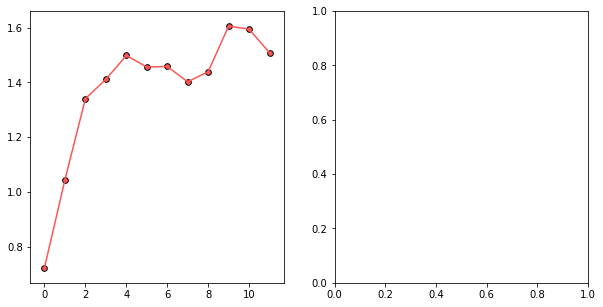

In [1529]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
                    
mae_pred = []
for i in np.arange(0,multi_labels_0.shape[1],step=32):
    mae = mean_absolute_error(multi_labels_0[:,i:i+32], multi_preds_0[:,i:i+32])
    mae_pred.append(mae)
df = pd.DataFrame(mae_pred, columns=['mae'])

ax[0].plot(df.index, df.mae, c='#ff5555')
ax[0].scatter(df.index, df.mae,edgecolors='k', c='#ff5555', s=32 )

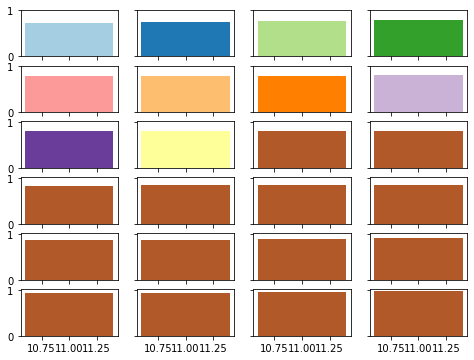

In [1507]:
fig, axes = plt.subplots(6,4, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    mae_pred = pd.Dataframe()
    for time,value in enumerate(np.arange(0,multi_labels_0.shape[1],step=32)):
        mae = mean_absolute_error(multi_labels_0[:,i:i+32], multi_preds_0[:,i:i+32])
        mae_pred['time']=time
        mae_pred['mae']=mae
    
    ax.line(time,mae, color=plt.cm.Paired(i/10.))

plt.show()

In [1470]:
multi_preds_0

NameError: name 'multi_preds_0' is not defined

In [1574]:
df2[df2['var']=='ATAvg'].time

0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
Name: time, dtype: int64

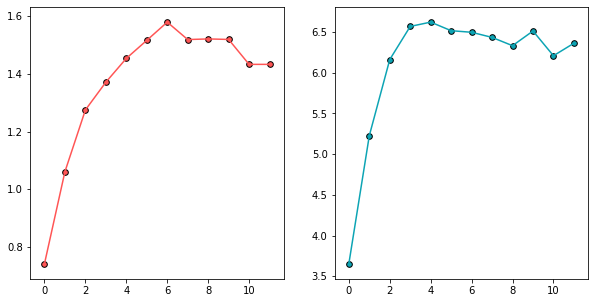

In [1579]:
mae_pred = []
r2_pred = []        
for i in np.arange(0,multi_labels_0.shape[1],step=32):
    mae = mean_absolute_error(multi_labels_0[:,i:i+32], multi_preds_0[:,i:i+32])
    mae_pred.append(mae)
    r2 = round(r2_score(multi_labels_0[:,i:i+32], multi_preds_0[:,i:i+32]),3)
    r2_pred.append(r2)
df = pd.DataFrame(mae_pred, columns=['mae'])
df['r2']=r2_pred
df['var']='ATAvg'
df['time']=df.index
        
mae_pred = []
r2_pred = []
for i in np.arange(0,multi_labels_1.shape[1],step=32):
    mae = mean_absolute_error(multi_labels_1[:,i:i+32], multi_preds_1[:,i:i+32])
    mae_pred.append(mae)
    r2 = round(r2_score(multi_labels_1[:,i:i+32], multi_preds_1[:,i:i+32]),3)
    r2_pred.append(r2)
df1 = pd.DataFrame(mae_pred, columns=['mae'])
df1['r2']=r2_pred
df1['var']='RHAvg'
df1['time']=df1.index
df2 = df.append(df1)
accuracy = df2.to_dict()
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(df.time, df.mae, c='#ff5555')
ax[0].scatter(df.time, df.mae,edgecolors='k', c='#ff5555', s=32 )
ax[1].plot(df1.time, df1.mae, c='#0ca4b4')
ax[1].scatter(df1.time, df1.mae,edgecolors='k', c='#0ca4b4', s=32 )

In [1589]:
from sklearn.metrics import r2_score
import math
from scipy import stats

def get_predictions(self, model = lstm_model, plot_col = ['ATAvg','RHAvg'], plot=True):
    
    
    plot_col_index_0 = self.column_indices[plot_col[0]]
    plot_col_index_1 = self.column_indices[plot_col[1]]
    all_preds_0=[]
    all_labels_0 =[]
    all_preds_1=[]
    all_labels_1 =[]
    
    n_batches = len(tuple(self.test))
    if self.shift==1:
        for i in range(n_batches):
            for inputs, labels in self.test.take(i):  # iterate over batches
            
                numpy_labels = labels.numpy() ### get labels
                numpy_inputs = inputs.numpy() ### get inputs
                preds = model(numpy_inputs) ### make prediction from trined model
                numpy_preds = preds.numpy() ### get predictions
                
                batch_pred_0 =numpy_preds[:,-1,plot_col_index_0]*train_std[plot_col_index_0] + train_mean[plot_col_index_0]
                batch_label_0 = numpy_labels[:,-1,plot_col_index_0]*train_std[plot_col_index_0] + train_mean[plot_col_index_0]
                batch_pred_1 =numpy_preds[:,-1,plot_col_index_1]*train_std[plot_col_index_1] + train_mean[plot_col_index_1]
                batch_label_1 = numpy_labels[:,-1,plot_col_index_1]*train_std[plot_col_index_1] + train_mean[plot_col_index_1]
        
                all_preds_0.extend(batch_pred_0)
                all_labels_0.extend(batch_label_0)
                all_preds_1.extend(batch_pred_1)
                all_labels_1.extend(batch_label_1)
                
        r2_0=round(r2_score(all_labels_0, all_preds_0),3)
        r2_1=round(r2_score(all_labels_1, all_preds_1),3)
        mae_0 = mean_absolute_error(all_labels_0, all_preds_0)
        mae_1 = mean_absolute_error(all_labels_1, all_preds_1)
                
        accuracy = {'r2':{plot_col[0]:r2_0,plot_col[1]:r2_1},
                            'mae':{plot_col[0]:mae_0,plot_col[1]:mae_1}}

        if plot:
            ## var 0 (ATAvg)
            slope, intercept, r_value_0, p_value, std_err = stats.linregress(all_labels_0, all_preds_0)
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].scatter(all_labels_0, all_preds_0,edgecolors='k', c='#ff5555', s=32)
            ax[0].set_xlabel(f'True Values {plot_col[0]} [de-normed]')
            ax[0].set_ylabel(f'Predicted Values {plot_col[0]} [de-normed]')
            lims = [math.floor(min(all_labels_0)-min(all_labels_0)*0.1), math.ceil(max(all_labels_0)+max(all_labels_0)*0.1)]
            ax[0].set_xlim(lims)
            ax[0].set_ylim(lims)
            line = slope*np.array(all_labels_0)+intercept
            ax[0].plot(all_labels_0, line, 'gray',label = f'r2 = {round(r_value_0**2,3)}')
            ax[0].legend(loc = 'lower right')

            ## var 1 (RHvg)
            slope, intercept, r_value_1, p_value, std_err = stats.linregress(all_labels_1, all_preds_1)
            ax[1].scatter(all_labels_1, all_preds_1,edgecolors='k', c='#0ca4b4', s=32)
            ax[1].set_xlabel(f'True Values {plot_col[1]} [de-normed]')
            ax[1].set_ylabel(f'Predicted Values {plot_col[1]} [de-normed]')
            lims = [math.floor(min(all_labels_1)-min(all_labels_1)*0.1), math.ceil(max(all_labels_1)+max(all_labels_1)*0.1)]
            ax[1].set_xlim(lims)
            ax[1].set_ylim(lims)
            line = slope*np.array(all_labels_1)+intercept
            ax[1].plot(all_labels_1, line, 'gray',label = f'r2 = {round(r_value_1**2,3)}')
            ax[1].legend(loc = 'lower right')

    else:
        for i in range(n_batches):
            #print(f'i = {i}')
            for inputs, labels in self.test.take(i):  # iterate over batches
                
                numpy_labels = labels.numpy() ### get labels
                numpy_inputs = inputs.numpy() ### get inputs
                preds = model(numpy_inputs) ### make prediction from trined model
                numpy_preds = preds.numpy() ### get predictions
                
                all_preds_by_time_0 = []
                all_labels_by_time_0 = []
                all_preds_by_time_1 = []
                all_labels_by_time_1 = []
                
                for j in range(numpy_labels_test.shape[1]): ## number of time steps
                    ### get values for each bacth and time and de-normalize
                    #print(f'j = {j}')
                    batch_pred_0 =numpy_preds[:,j,plot_col_index_0]*train_std[plot_col_index_0] + train_mean[plot_col_index_0]
                    batch_label_0 = numpy_labels[:,j,plot_col_index_0]*train_std[plot_col_index_0] + train_mean[plot_col_index_0]
                    batch_pred_1 =numpy_preds[:,j,plot_col_index_1]*train_std[plot_col_index_1] + train_mean[plot_col_index_1]
                    batch_label_1 = numpy_labels[:,j,plot_col_index_1]*train_std[plot_col_index_1] + train_mean[plot_col_index_1]
        
                    all_preds_by_time_0.extend(batch_pred_0)
                    #print(f'all_preds_by_time = {len(all_preds_by_time_0)}')
                    all_labels_by_time_0.extend(batch_label_0)
                    all_preds_by_time_1.extend(batch_pred_1)
                    all_labels_by_time_1.extend(batch_label_1)
                
            
                all_preds_0.append(all_preds_by_time_0)
                all_labels_0.append(all_labels_by_time_0)
                all_preds_1.append(all_preds_by_time_1)
                all_labels_1.append(all_labels_by_time_1)
                if len(all_preds_0) >= i:
                    break
        
                ## covert to array (shape= i,time*batch_size)
        multi_preds_0 = np.vstack(all_preds_0)
        multi_labels_0 = np.vstack(all_labels_0)
        multi_preds_1 = np.vstack(all_preds_1)
        multi_labels_1 = np.vstack(all_labels_1)
        
        mae_pred = []
        r2_pred = []        
        for a in np.arange(0,multi_labels_0.shape[1],step=32):
            mae = mean_absolute_error(multi_labels_0[:,a:a+32], multi_preds_0[:,a:a+32])
            mae_pred.append(mae)
            r2 = round(r2_score(multi_labels_0[:,a:a+32], multi_preds_0[:,a:a+32]),3)
            r2_pred.append(r2)
        df = pd.DataFrame(mae_pred, columns=['mae'])
        df['r2']=r2_pred
        df['var']='ATAvg'
        df['time']=df.index

        mae_pred = []
        r2_pred = []
        for a in np.arange(0,multi_labels_1.shape[1],step=32):
            mae = mean_absolute_error(multi_labels_1[:,a:a+32], multi_preds_1[:,a:a+32])
            mae_pred.append(mae)
            r2 = round(r2_score(multi_labels_1[:,a:a+32], multi_preds_1[:,a:a+32]),3)
            r2_pred.append(r2)
        df1 = pd.DataFrame(mae_pred, columns=['mae'])
        df1['r2']=r2_pred
        df1['var']='RHAvg'
        df1['time']=df1.index
        df2 = df.append(df1)
        accuracy = df2.to_dict()  
              
        if plot:
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].plot(df.time, df.mae, c='#ff5555')
            ax[0].scatter(df.time, df.mae,edgecolors='k', c='#ff5555', s=32 )
            ax[1].plot(df1.time, df1.mae, c='#0ca4b4')
            ax[1].scatter(df1.time, df1.mae,edgecolors='k', c='#0ca4b4', s=32 )
            
    return accuracy
                       
WindowGenerator.get_predictions = get_predictions

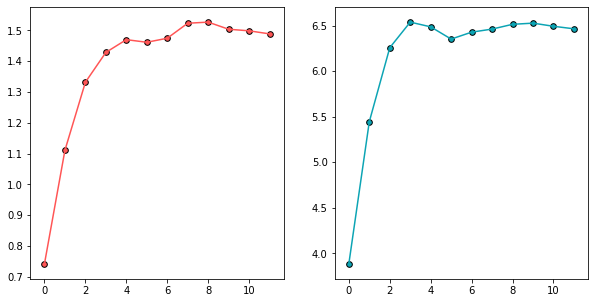

In [1585]:
accuracy= wm48_12.get_predictions(multi_linear_model)

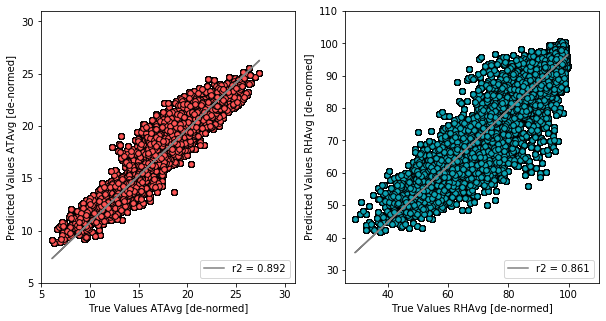

In [1590]:
accuracy=w24_1.get_predictions(lstm_model)

In [1591]:
accuracy

{'r2': {'ATAvg': 0.892, 'RHAvg': 0.86},
 'mae': {'ATAvg': 0.84437513, 'RHAvg': 4.485748}}